[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bradley-Buchner/worm_synergy/blob/master/notebooks/model_demo.ipynb)

# SynergyGT (Synergy Graph Transformer) Model Demo
This notebook demonstrates how to use the SynergyGT model to predict the likelihood that two genes determine lifespan synergistically. Run the cells below in-order to load and preprocess data, build and train a model, evaluate its performance on a held-out test set, and inspect its learned weights.

In [ ]:
!git clone https://github.com/Bradley-Buchner/worm_synergy.git
!pip install torch-geometric torchmetrics

In [ ]:
import os
print(os.getcwd())
os.chdir('worm_synergy')
print(os.getcwd())

In [181]:
import pickle
import importlib

import model
from model.preprocessing import *
from model.models import *
from model.utils import *

importlib.reload(model.preprocessing)
importlib.reload(model.models)
importlib.reload(model.utils)

<module 'model.utils' from '/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/utils.py'>

## Load and preprocess data
The Synergy GT model relies on two primary data objects/sources: 1) the organism's full genetic interaction network (extracted from WormBase), and 2) double mutant lifespan data from SynergyAge, which consists of lifespan changes that occur when two genes are mutated (perturbed) simultaneously.

Both of these data are contained in a PyG Data object, which we will load into our environment.

We'll also load a few namespace mapping dictionaries:
* perturbation2idx
* node2id
* id2node

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = torch.load('data/worm_synergy_pyg_data_demo_raw.pt', map_location=device, weights_only=False)

with open("data/node2id.pkl", 'rb') as f:
    node2id = pickle.load(f)

with open("data/id2node.pkl", 'rb') as f:
    id2node = pickle.load(f)

### Summarize genetic interaction network from WormBase

The PyG data object holds indexes of nodes (genes), edges, edge types, and more. We can use these and the `degree` function from PyG to get some basic statistics about the network.

In [183]:
print("=== Genetic Interaction Network Summary ===")
out_degree = degree(data.edge_index[0], num_nodes=data.num_nodes)
in_degree = degree(data.edge_index[1], num_nodes=data.num_nodes)
avg_degree = torch.median(torch.cat([in_degree, out_degree], dim=0)).item()
max_degree = torch.max(torch.cat([in_degree, out_degree], dim=0)).item()

print(f"Total number of nodes: {data.num_nodes}")
print(f"Total number of edges: {data.num_edges}")
print(f"Median node degree: {avg_degree:.0f}")
print(f"Maximum node degree: {max_degree:.0f}")
print(f"Types of interactions/edges: {data.edge_type.max().item() + 1} (genetic, physical, and regulatory)")
print("Directed? => TRUE")

=== Genetic Interaction Network Summary ===
Total number of nodes: 11493
Total number of edges: 90364
Median node degree: 2
Maximum node degree: 1737
Types of interactions/edges: 3 (genetic, physical, and regulatory)
Directed? => TRUE


### SynergyAge data preparation
The SynergyAge data consists of double mutant experiments and their corresponding lifespan changes categorized into one of three effect types: antagonistic, additive, or synergistic. See README.md for how exactly these are defined. Since some experiments appear more than once, the data is aggregated into unique double mutants (pairs of perturbed genes and their corresponding perturbation types), and instead of using a single effect type label, frequencies for each of the three effect types are stored in a 3-dimensional vector.

To account for the fact that the number of experiments for each unique double mutant is variable, and that double mutant effect type confidence increases with experiment quantity, we'll use a Bayesian smoothing technique to enforce a simple prior and smooth effect type frequencies.

We'll use the `process_data_to_soft_smoothed_label_dist` function from `model.preprocessing` to group unique double mutants in `data`, build effect type distributions, and apply Bayesian smoothing with an uninformative prior to the resulting distributions. This will produce a new PyG Data object `data_processed`

In [188]:
# Initialize a prior distribution with pseudocounts of 1 for each effect type
uninformative_prior = torch.tensor([1.0, 1.0, 1.0]).to("mps")

data_processed = process_data_to_soft_smoothed_label_dist(data, prior=uninformative_prior, effect_type_key='pair_effect_type_index', pair_index_key='pair_index', pair_pert_index_key='pair_pert_index')

data_processed

Data(x=[11493, 11493], edge_index=[2, 90364], node_index=[11493], edge_type=[90364], x_embed_go=[11493, 4], x_embed_disease=[11493, 4], x_embed_anatomy=[11493, 4], x_embed_phenotype_comb=[11493, 4], x_embed_development=[11493, 4], x_embed_pt5=[11493, 1024], x_embed_pt5_pca=[11493, 4], pair_effect=[1431], lifespan_association=[11493], lifespan_dist=[11493], name='data_effect_type', pair_pert_group_index=[4, 802], pair_effect_type_soft=[802, 3], pair_effect_type_soft_smoothed=[802, 3], pair_obs_counts=[802, 3], pair_obs_total_counts=[802])

### Summarize experimental data from SynergyAge
To get familiar with the processed SynergyAge data, we can inspect unique double mutants in `data_processed.pair_pert_group_index`, their relative effect type frequencies in `data_processed.pair_effect_type_soft`, and their smoothed frequencies in `data_processed.pair_effect_type_soft_smoothed`.

In [185]:
print("=== Quick View of data_processed ===")
print(f"\n--- data_processed.pair_pert_group_index: ---"
      f"\nContent: tensor([[gene1_id, gene1_perturbation_id, gene2_id, gene2_perturbation_id], ...])"
      f"\nData: {data_processed.pair_pert_group_index.t()}")

print(f"\n--- data_processed.pair_effect_type_soft: ---"
      f"\nContent: tensor([[fraction_antagonistic, fraction_additive, fraction_synergistic], ...])"
      f"\nData: {data_processed.pair_effect_type_soft}")

print(f"\n--- data_processed.pair_effect_type_soft_smoothed: ---"
      f"\nContent: tensor([[fraction_antagonistic_smoothed, fraction_additive_smoothed, fraction_synergistic_smoothed], ...])"
      f"\nData: {data_processed.pair_effect_type_soft_smoothed}")

=== Quick View of data_processed ===

--- data_processed.pair_pert_group_index: ---
Content: tensor([[gene1_id, gene1_perturbation_id, gene2_id, gene2_perturbation_id], ...])
Data: tensor([[    0,     0,    34,     1],
        [    3,     1,  1609,     0],
        [    3,     1,  1698,     0],
        ...,
        [ 5090,     1,  8566,     1],
        [ 5647,     1,  9412,     1],
        [ 8981,     0, 11115,     1]], device='mps:0')

--- data_processed.pair_effect_type_soft: ---
Content: tensor([[fraction_antagonistic, fraction_additive, fraction_synergistic], ...])
Data: tensor([[0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        ...,
        [0.5000, 0.0000, 0.5000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000]], device='mps:0')

--- data_processed.pair_effect_type_soft_smoothed: ---
Content: tensor([[fraction_antagonistic_smoothed, fraction_additive_smoothed, fraction_synergistic_smoothed], ...])
Data: tensor(

Let's look a bit deeper into the data from SynergyAge

In [186]:
print("=== SynergyAge Data Summary ===")
print(f"Number of unique gene pairs: {data_processed.pair_obs_total_counts.shape[0]}")
print(f"Avg. number of experiments for each gene pair: {data_processed.pair_obs_total_counts.mean():.2f}")

sorted_counts, sorted_indices = data_processed.pair_obs_total_counts.sort(descending=True)
top_k = 5
print(f"\n=== Top {top_k} Gene Pairs by Experiment Count ===")
for i in range(top_k):
    idx = sorted_indices[i]
    count = sorted_counts[i].item()
    gene_id_1 = data_processed.pair_pert_group_index[0, idx].item()
    gene_id_2 = data_processed.pair_pert_group_index[2, idx].item()
    gene_name_1 = id2node[gene_id_1]
    gene_name_2 = id2node[gene_id_2]
    print(f"Rank {i+1}: Genes: ({gene_name_1}, {gene_name_2}) - Count: {int(count)}")

# --- Global Averages ---
# Calculate mean across all pairs
avg_effects = data_processed.pair_effect_type_soft.mean(dim=0)
print("\n=== Average of Interaction Type Frequencies ===")
print(f"Avg. Antagonistic fraction: {avg_effects[0].item():.1%}")
print(f"Avg. Neither fraction:      {avg_effects[1].item():.1%}")
print(f"Avg. Synergistic fraction:  {avg_effects[2].item():.1%}")

avg_effects_smoothed = data_processed.pair_effect_type_soft_smoothed.mean(dim=0)
print("\nAfter Bayesian Smoothing with Uninformative Prior (pseudocounts of 1 for each):")
print(f"Avg. Antagonistic fraction: {avg_effects_smoothed[0].item():.1%}")
print(f"Avg. Neither fraction:      {avg_effects_smoothed[1].item():.1%}")
print(f"Avg. Synergistic fraction:  {avg_effects_smoothed[2].item():.1%}")

# --- Top Pairs ---
sorted_counts, sorted_indices = data_processed.pair_obs_total_counts.sort(descending=True)
top_k = 5

print(f"\n=== Top {top_k} Gene Pairs by Experiment Count ===")

for i in range(top_k):
    idx = sorted_indices[i]
    count = sorted_counts[i].item()
    gene_id_1 = data_processed.pair_pert_group_index[0, idx].item()
    gene_id_2 = data_processed.pair_pert_group_index[2, idx].item()
    gene_name_1 = id2node[gene_id_1]
    gene_name_2 = id2node[gene_id_2]
    effects = data_processed.pair_effect_type_soft[idx]

    print(f"\nRank {i+1}: ({gene_name_1}, {gene_name_2}) | Count: {int(count)}")
    print(f"    Breakdown: Antagonistic: {effects[0]:.1%}, Additive: {effects[1]:.1%}, Synergistic: {effects[2]:.1%}")

=== SynergyAge Data Summary ===
Number of unique gene pairs: 802
Avg. number of experiments for each gene pair: 1.78

=== Top 5 Gene Pairs by Experiment Count ===
Rank 1: Genes: (daf-2, skn-1) - Count: 23
Rank 2: Genes: (vhl-1, hif-1) - Count: 18
Rank 3: Genes: (daf-16, hif-1) - Count: 15
Rank 4: Genes: (daf-2, rsks-1) - Count: 14
Rank 5: Genes: (sir-2.1, hcf-1) - Count: 14

=== Average of Interaction Type Frequencies ===
Avg. Antagonistic fraction: 4.9%
Avg. Neither fraction:      74.4%
Avg. Synergistic fraction:  20.7%

After Bayesian Smoothing with Uninformative Prior (pseudocounts of 1 for each):
Avg. Antagonistic fraction: 24.0%
Avg. Neither fraction:      47.2%
Avg. Synergistic fraction:  28.8%

=== Top 5 Gene Pairs by Experiment Count ===

Rank 1: (daf-2, skn-1) | Count: 23
    Breakdown: Antagonistic: 0.0%, Additive: 95.7%, Synergistic: 4.3%

Rank 2: (vhl-1, hif-1) | Count: 18
    Breakdown: Antagonistic: 22.2%, Additive: 77.8%, Synergistic: 0.0%

Rank 3: (daf-16, hif-1) | Coun

### Build gene-pair subgraphs for the transformer model
SynergyGT makes predictions for gene pairs by aggregating information from subgraphs containing the pair and all 1-hop neighbors of each gene in the pair. We'll construct these subgraphs using the `preprocess_and_save_subgraphs_graphormer` function from `model.preprocessing`. The function takes a PyG Data object `data` and a dictionary of preprocessing parameters `configs`, and returns a list of dictionaries containing information about each gene pair's subgraph. Each subgraph's dictionary contains the following keys:
- `pair`: a tuple of gene IDs for the pair of perturbed genes used to construct the subgraph (the focal genes)
- `pair_perturbations`: the perturbation types for each gene in the pair
- `node_ids`: a list of node IDs for all nodes in the subgraph
- `dist_to_u`: the shortest distance between the pair's first gene and any node in the subgraph
- `dist_to_v`: the shortest distance between the pair's second gene and any node in the subgraph
- `adj_matrix`: an adjacency matrix encoding the connectedness of the subgraph
- `average_edge_type_encoding`: a matrix encoding the average edge type connecting two genes in the subgraph
- `pairwise_dist`: a matrix encoding the shortest distance between any two nodes in the subgraph
- `in_degree`: the number of incoming edges for each gene in the subgraph
- `out_degree`: the number of outgoing edges for each gene in the subgraph
- `in_degree_binned`: gene in-degree binned into K bins
- `out_degree_binned`: gene out-degree binned into K bins
- `is_lifespan_gene`: a vector indicating the lifespan association of each gene in the subgraph
- `is_mutual_interactor`: a vector indicating whether each gene in the subgraph is a mutual interactor for the perturbed/focal pair of genes
- `lifespan_dist`: the hop distance to the nearest aging-associated gene

In [187]:
# --- Build k-hop subgraphs ---
spd_filepath = "data/graph_transformer/spd_matrix.pt"
spd_tensor = torch.load(spd_filepath, weights_only=False)

configs = {
    'max_spd': spd_tensor.max().item(),
    'max_dist_uv': spd_tensor.max().item(),
    'k_hop': 1,
    'sampling_mode': 'union',
    'target_subgraph_size': 0,
    'max_in_degree': max_degree,
    'max_out_degree': max_degree,
    'num_degree_bins': 5,
    'attributes_dir': 'data/graph_transformer',
    'output_path': 'data/synergy_gt_subgraphs.pt',
    'device': 'cpu'
}

subgraph_data = generate_subgraph_samples(
    data=data_processed,
    configs=configs
)

--- Starting Subgraph Pre-processing ---
Mode: union, Target Augmentation Size: 0, Device: cpu
Loading pre-computed attributes from ../data/graph_transformer...

Processing 802 pairs...
Target soft/smoothed data found.


Building Subgraphs: 100%|██████████| 802/802 [00:03<00:00, 230.03it/s]



Processing complete. Saving 802 samples to ../data/synergy_gt_subgraphs.pt
Processed samples saved successfully to ../data/synergy_gt_subgraphs.pt
--- Pre-processing finished successfully! ---


### Prepare subgraph data for model training

In [104]:
# --- Make train/test split ---
train_list, test_list = train_test_split_simple(subgraph_data, train_frac=0.8, seed=23)
print(f"# of training samples (gene pairs): {len(train_list)}")
print(f"# of test samples (gene pairs): {len(test_list)}")
train_pairs = [pair_data.get('pair') for pair_data in train_list]
test_pairs = [pair_data.get('pair') for pair_data in test_list]
if not set(train_pairs).isdisjoint(set(test_pairs)):
    print("Warning: LEAKAGE... Training pair found in test set.")
else:
    print("No leakage detected between training and test sets. Good to go!")

# of training samples (gene pairs): 641
# of test samples (gene pairs): 161
No leakage detected between training and test sets. Good to go!


### Inspect model training data (gene-pair subgraphs)

In [105]:
# Summary of subgraph data
train_dataset = PairSubgraphDataset(train_list)
test_dataset = PairSubgraphDataset(test_list)

subgraph_size = []
max_dists_to_u_or_v = []
for sample in train_dataset:
    N_subgraph = len(sample['node_ids'])
    subgraph_size.append(N_subgraph)
    max_dist_to_u = sample['dist_to_u'].max().item()
    max_dist_to_v = sample['dist_to_v'].max().item()
    max_to_u_or_v = max(max_dist_to_u, max_dist_to_v)
    max_dists_to_u_or_v.append(max_to_u_or_v)

print("=== Subgraph Data Summary (Training Set) ===")
print(f"Mean subgraph size: {np.mean(subgraph_size):.0f}")
print(f"Median subgraph size: {np.median(subgraph_size):.0f}")
print(f"Max subgraph size: {np.max(subgraph_size)}")
print(f"Min subgraph size: {np.min(subgraph_size)}")
print(f"Furthest dist from u or v: {np.max(max_dists_to_u_or_v)}")

=== Subgraph Data Summary (Training Set) ===
Mean subgraph size: 141
Median subgraph size: 182
Max subgraph size: 515
Min subgraph size: 3
Furthest dist from u or v: 6


By taking a sample from the training set we can visualize its subgraph structure.

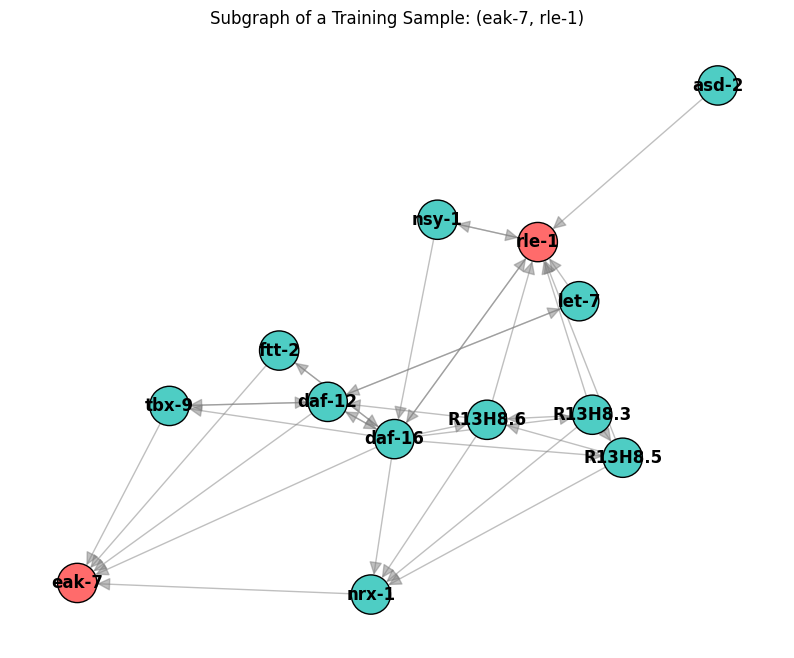

In [107]:
sample = train_dataset[1]
subset_nodes = sample['node_ids']
focal_pair = sample['pair']

edge_index_sub, _ = subgraph(
    subset_nodes,
    data_processed.edge_index,
    relabel_nodes=False
)

G = nx.DiGraph()
G.add_nodes_from(subset_nodes.tolist())
G.add_edges_from(edge_index_sub.t().tolist())

node_colors = []
for node in G.nodes():
    if node in focal_pair.tolist():
        node_colors.append('#ff6b6b')
    else:
        node_colors.append('#4ecdc4')

node_labels = {node: id2node.get(node, node) for node in G.nodes()}
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, arrows=True, arrowstyle='-|>',  arrowsize=20, node_size=800)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black', font_weight='bold')

focal_pair_label = f"({id2node[focal_pair[0].item()]}, {id2node[focal_pair[1].item()]})"
plt.title(f"Subgraph of a Training Sample: {focal_pair_label}")
plt.axis('off')
plt.show()

## Train a model
Now that the data is structured into gene-pair subgraphs, we can initialize the SynergyGT model. This model uses a Graph Transformer architecture to process the genes and gene relationships within each subgraph to predict whether the focal gene pair synergistically affects lifespan, taking into account causality, proximity, and biological semantics of relationships.

In [108]:
pert_a_max = data_processed.pair_pert_group_index[1].max().item()
pert_b_max = data_processed.pair_pert_group_index[3].max().item()
pert_padding = max(pert_a_max, pert_b_max) + 1

collate_fn_padding = {
    'node_ids': data.num_nodes,
    'node_perturbations': pert_padding,
    'in_degree': max_degree + 1,
    'out_degree': max_degree + 1,
    'dist_to_u': spd_tensor.max().item() + 1,
    'dist_to_v': spd_tensor.max().item() + 1,
    'pairwise_dist': spd_tensor.max().item() + 1,
    'adj_matrix': data_processed.edge_type.max().item() + 1,
    'average_edge_type_encoding': data_processed.edge_type.max().item() + 1,
    'lifespan_dist': data_processed.lifespan_dist.max().item() + 1
}

graphormer_collate = partial(graphormer_collate_fn, pad_values=collate_fn_padding)

train_dataset = PairSubgraphDataset(train_list)
test_dataset = PairSubgraphDataset(test_list)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=graphormer_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=graphormer_collate)

### Initialize model and hyperparameters
In this step, we define the structural hyperparameters of the Transformer, such as the number of layers, hidden dimensions, and attention heads. We also specify hyperparameters for training, like the number of training epochs, and move the model to the appropriate device (CPU, CUDA, or MPS).

We also specify our optimization strategy here, choosing a loss appropriate for label distribution learning (Kullback-Leibler divergence to compare predicted distributions against our Bayesian-smoothed soft label distributions) and the AdamW optimizer.

**Note:** SynergyGT expects specific values for some hyperparameters based on the preprocessing steps performed earlier and findings from hyperparameter tuning experiments.

In [162]:
num_epochs = 100
C = 3

params = {
    'sum_node_features': True,
    'use_pretrained_gene_embs': False,
    'fine_tune_gene_emb': False,
    'fine_tune_ont_emb': False,
    'randomize_labels': False,
    'max_spd': spd_tensor.max().item(),
    # 'max_spd': 3,
    'num_degree_bins': 5,
    'dropout_p': 0.1,
    'd_model': 8,
    'num_heads': 2,
    'num_layers': 6
}

model = SynergyGT(
    graph_data = data_processed,
    params = params
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=0.0
            )
loss_fn = nn.KLDivLoss(reduction='batchmean')

print(f"Synergy Graph Transformer Model Architecture: \n\n{model}")

Synergy Graph Transformer Model Architecture: 

RelationalPairClassifierGraphormer(
  (node_identity_embedding): Embedding(11494, 8, padding_idx=11493)
  (dist_uv_embedding): Embedding(10, 8)
  (in_degree_embedding): Embedding(5, 8)
  (out_degree_embedding): Embedding(5, 8)
  (lifespan_dist_embedding): Embedding(6, 8, padding_idx=5)
  (perturbation_embedding): Embedding(4, 8, padding_idx=3)
  (pairwise_dist_embedding): Embedding(10, 2, padding_idx=9)
  (edge_type_embedding): Embedding(3, 2, padding_idx=2)
  (mutual_interactor_bias_emb): Embedding(2, 2)
  (dist_uv_bias_embedding): Embedding(10, 2)
  (value_projections): ModuleDict(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x RelationalGTEncoderLayer(
      (value_projections): ModuleDict(
        (0): Linear(in_features=8, out_features=8, bias=True)
        (

We'll now train the model for the number of epochs specified above (should be 100). During each epoch, the model processes subgraphs in batches, calculates the label distribution loss, and updates its weights. We track both the model's training and validation loss to monitor convergence and generalization.

Training the model should take about 5 minutes (if training for ~100 epochs), or skip this cell and load in a pretrained model in the next cell.

In [163]:
# Run this cell only if you want to train from scratch. This will take about 5 mins.
# If not, skip to the next cell and load a pre-trained model.

training_results, test_preds = train_synergy_model(model, train_loader, test_loader, label_name='target_soft_smoothed', optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, device=device, randomize_labels=params.get('randomize_labels'), num_epochs=num_epochs, num_classes=C)

Epoch 001


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.55it/s]


lr=0.0009755282581475768  train_loss=0.1043  test_loss=0.0713

Epoch 002


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.65it/s]


lr=0.0009045084971874737  train_loss=0.0629  test_loss=0.0635

Epoch 003


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.85it/s]


lr=0.0007938926261462366  train_loss=0.0616  test_loss=0.0630

Epoch 004


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.85it/s]


lr=0.0006545084971874737  train_loss=0.0610  test_loss=0.0637

Epoch 005


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.64it/s]


lr=0.0005  train_loss=0.0613  test_loss=0.0630

Epoch 006


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.02it/s]


lr=0.00034549150281252633  train_loss=0.0591  test_loss=0.0629

Epoch 007


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.93it/s]


lr=0.00020610737385376348  train_loss=0.0597  test_loss=0.0628

Epoch 008


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.55it/s]


lr=9.549150281252633e-05  train_loss=0.0599  test_loss=0.0628

Epoch 009


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.80it/s]


lr=2.4471741852423235e-05  train_loss=0.0598  test_loss=0.0628

Epoch 010


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.62it/s]


lr=0.001  train_loss=0.0608  test_loss=0.0628

Epoch 011


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.78it/s]


lr=0.0009938441702975688  train_loss=0.0599  test_loss=0.0630

Epoch 012


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.23it/s]


lr=0.0009755282581475768  train_loss=0.0601  test_loss=0.0625

Epoch 013


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.76it/s]


lr=0.0009455032620941839  train_loss=0.0602  test_loss=0.0625

Epoch 014


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.04it/s]


lr=0.0009045084971874737  train_loss=0.0583  test_loss=0.0619

Epoch 015


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.94it/s]


lr=0.0008535533905932737  train_loss=0.0575  test_loss=0.0621

Epoch 016


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.58it/s]


lr=0.0007938926261462366  train_loss=0.0594  test_loss=0.0619

Epoch 017


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.33it/s]


lr=0.0007269952498697733  train_loss=0.0592  test_loss=0.0615

Epoch 018


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.69it/s]


lr=0.0006545084971874737  train_loss=0.0584  test_loss=0.0614

Epoch 019


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.05it/s]


lr=0.0005782172325201155  train_loss=0.0572  test_loss=0.0612

Epoch 020


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.34it/s]


lr=0.0005  train_loss=0.0566  test_loss=0.0609

Epoch 021


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.36it/s]


lr=0.0004217827674798847  train_loss=0.0568  test_loss=0.0606

Epoch 022


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.79it/s]


lr=0.00034549150281252633  train_loss=0.0579  test_loss=0.0603

Epoch 023


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.96it/s]


lr=0.00027300475013022663  train_loss=0.0569  test_loss=0.0605

Epoch 024


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.08it/s]


lr=0.00020610737385376348  train_loss=0.0560  test_loss=0.0602

Epoch 025


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.15it/s]


lr=0.00014644660940672628  train_loss=0.0566  test_loss=0.0602

Epoch 026


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.59it/s]


lr=9.549150281252633e-05  train_loss=0.0553  test_loss=0.0598

Epoch 027


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.82it/s]


lr=5.449673790581611e-05  train_loss=0.0565  test_loss=0.0597

Epoch 028


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.11it/s]


lr=2.4471741852423235e-05  train_loss=0.0575  test_loss=0.0596

Epoch 029


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.98it/s]


lr=6.15582970243117e-06  train_loss=0.0560  test_loss=0.0596

Epoch 030


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.07it/s]


lr=0.001  train_loss=0.0566  test_loss=0.0596

Epoch 031


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.01it/s]


lr=0.000998458666866564  train_loss=0.0571  test_loss=0.0594

Epoch 032


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.95it/s]


lr=0.0009938441702975688  train_loss=0.0584  test_loss=0.0593

Epoch 033


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.03it/s]


lr=0.0009861849601988384  train_loss=0.0563  test_loss=0.0600

Epoch 034


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.74it/s]


lr=0.0009755282581475768  train_loss=0.0582  test_loss=0.0578

Epoch 035


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.11it/s]


lr=0.0009619397662556434  train_loss=0.0550  test_loss=0.0583

Epoch 036


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.71it/s]


lr=0.0009455032620941839  train_loss=0.0565  test_loss=0.0570

Epoch 037


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.15it/s]


lr=0.0009263200821770461  train_loss=0.0554  test_loss=0.0576

Epoch 038


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.52it/s]


lr=0.0009045084971874737  train_loss=0.0556  test_loss=0.0555

Epoch 039


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.73it/s]


lr=0.0008802029828000156  train_loss=0.0530  test_loss=0.0550

Epoch 040


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.19it/s]


lr=0.0008535533905932737  train_loss=0.0528  test_loss=0.0556

Epoch 041


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.54it/s]


lr=0.000824724024165092  train_loss=0.0528  test_loss=0.0549

Epoch 042


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.88it/s]


lr=0.0007938926261462366  train_loss=0.0520  test_loss=0.0545

Epoch 043


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.25it/s]


lr=0.0007612492823579744  train_loss=0.0522  test_loss=0.0554

Epoch 044


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


lr=0.0007269952498697733  train_loss=0.0517  test_loss=0.0543

Epoch 045


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.41it/s]


lr=0.000691341716182545  train_loss=0.0507  test_loss=0.0546

Epoch 046


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


lr=0.0006545084971874737  train_loss=0.0515  test_loss=0.0549

Epoch 047


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.91it/s]


lr=0.0006167226819279528  train_loss=0.0506  test_loss=0.0537

Epoch 048


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.01it/s]


lr=0.0005782172325201155  train_loss=0.0494  test_loss=0.0542

Epoch 049


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.42it/s]


lr=0.0005392295478639225  train_loss=0.0510  test_loss=0.0536

Epoch 050


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.79it/s]


lr=0.0005  train_loss=0.0502  test_loss=0.0549

Epoch 051


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.16it/s]


lr=0.0004607704521360776  train_loss=0.0483  test_loss=0.0526

Epoch 052


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


lr=0.0004217827674798847  train_loss=0.0488  test_loss=0.0542

Epoch 053


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.38it/s]


lr=0.00038327731807204733  train_loss=0.0474  test_loss=0.0526

Epoch 054


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.13it/s]


lr=0.00034549150281252633  train_loss=0.0465  test_loss=0.0530

Epoch 055


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.44it/s]


lr=0.0003086582838174551  train_loss=0.0469  test_loss=0.0538

Epoch 056


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.38it/s]


lr=0.00027300475013022663  train_loss=0.0470  test_loss=0.0526

Epoch 057


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.76it/s]


lr=0.00023875071764202561  train_loss=0.0471  test_loss=0.0528

Epoch 058


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.20it/s]


lr=0.00020610737385376348  train_loss=0.0464  test_loss=0.0525

Epoch 059


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.73it/s]


lr=0.00017527597583490823  train_loss=0.0460  test_loss=0.0526

Epoch 060


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.47it/s]


lr=0.00014644660940672628  train_loss=0.0467  test_loss=0.0526

Epoch 061


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


lr=0.00011979701719998459  train_loss=0.0475  test_loss=0.0527

Epoch 062


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.62it/s]


lr=9.549150281252633e-05  train_loss=0.0465  test_loss=0.0534

Epoch 063


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.81it/s]


lr=7.367991782295391e-05  train_loss=0.0468  test_loss=0.0551

Epoch 064


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.99it/s]


lr=5.449673790581611e-05  train_loss=0.0463  test_loss=0.0534

Epoch 065


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.02it/s]


lr=3.806023374435663e-05  train_loss=0.0460  test_loss=0.0531

Epoch 066


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.16it/s]


lr=2.4471741852423235e-05  train_loss=0.0459  test_loss=0.0531

Epoch 067


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.15it/s]


lr=1.3815039801161721e-05  train_loss=0.0457  test_loss=0.0530

Epoch 068


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.74it/s]


lr=6.15582970243117e-06  train_loss=0.0452  test_loss=0.0530

Epoch 069


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.26it/s]


lr=1.541333133436018e-06  train_loss=0.0464  test_loss=0.0529

Epoch 070


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.32it/s]


lr=0.001  train_loss=0.0449  test_loss=0.0529

Epoch 071


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.10it/s]


lr=0.0009996145181203615  train_loss=0.0473  test_loss=0.0528

Epoch 072


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.75it/s]


lr=0.000998458666866564  train_loss=0.0466  test_loss=0.0528

Epoch 073


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.57it/s]


lr=0.0009965342284774632  train_loss=0.0454  test_loss=0.0524

Epoch 074


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.29it/s]


lr=0.0009938441702975688  train_loss=0.0458  test_loss=0.0517

Epoch 075


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.68it/s]


lr=0.0009903926402016153  train_loss=0.0444  test_loss=0.0520

Epoch 076


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.94it/s]


lr=0.0009861849601988384  train_loss=0.0451  test_loss=0.0510

Epoch 077


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.81it/s]


lr=0.0009812276182268236  train_loss=0.0458  test_loss=0.0513

Epoch 078


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.13it/s]


lr=0.0009755282581475768  train_loss=0.0456  test_loss=0.0587

Epoch 079


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.40it/s]


lr=0.0009690956679612422  train_loss=0.0502  test_loss=0.0518

Epoch 080


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.52it/s]


lr=0.0009619397662556434  train_loss=0.0451  test_loss=0.0497

Epoch 081


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.72it/s]


lr=0.0009540715869125407  train_loss=0.0439  test_loss=0.0517

Epoch 082


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.58it/s]


lr=0.0009455032620941839  train_loss=0.0441  test_loss=0.0503

Epoch 083


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.91it/s]


lr=0.0009362480035363986  train_loss=0.0415  test_loss=0.0513

Epoch 084


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.87it/s]


lr=0.0009263200821770461  train_loss=0.0413  test_loss=0.0523

Epoch 085


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.21it/s]


lr=0.0009157348061512727  train_loss=0.0424  test_loss=0.0528

Epoch 086


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.82it/s]


lr=0.0009045084971874737  train_loss=0.0428  test_loss=0.0520

Epoch 087


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.08it/s]


lr=0.0008926584654403724  train_loss=0.0402  test_loss=0.0502

Epoch 088


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.97it/s]


lr=0.0008802029828000156  train_loss=0.0401  test_loss=0.0513

Epoch 089


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.92it/s]


lr=0.0008671612547178428  train_loss=0.0391  test_loss=0.0518

Epoch 090


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.15it/s]


lr=0.0008535533905932737  train_loss=0.0402  test_loss=0.0541

Epoch 091


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.34it/s]


lr=0.0008394003727664709  train_loss=0.0429  test_loss=0.0509

Epoch 092


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.01it/s]


lr=0.000824724024165092  train_loss=0.0410  test_loss=0.0521

Epoch 093


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.07it/s]


lr=0.000809546974654917  train_loss=0.0379  test_loss=0.0519

Epoch 094


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.89it/s]


lr=0.0007938926261462366  train_loss=0.0373  test_loss=0.0526

Epoch 095


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.11it/s]


lr=0.0007777851165098011  train_loss=0.0371  test_loss=0.0549

Epoch 096


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.75it/s]


lr=0.0007612492823579744  train_loss=0.0385  test_loss=0.0525

Epoch 097


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.80it/s]


lr=0.0007443106207484776  train_loss=0.0368  test_loss=0.0543

Epoch 098


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.83it/s]


lr=0.0007269952498697733  train_loss=0.0367  test_loss=0.0556

Epoch 099


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.13it/s]


lr=0.0007093298687687141  train_loss=0.0364  test_loss=0.0549

Epoch 100


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.87it/s]


lr=0.000691341716182545  train_loss=0.0364  test_loss=0.0548

Training complete!


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.85it/s]


In [172]:
# # Save the model
# save_path = '../data/demo_model.pth'
# torch.save({
#     "state_dict": model.state_dict(),
#     "history": model.history
# }, save_path)
# print(f"Model state and history saved to: {save_path}")

Model state and history saved to: ../data/demo_model.pth


In [173]:
saved_model = torch.load('../data/demo_model.pth', map_location=device, weights_only=False)
model_loaded = SynergyGT(
    graph_data=data_processed,
    params=params
).to(device)
model_loaded.load_state_dict(saved_model["state_dict"])
model_loaded.history = saved_model.get("history", {})   # safe fallback
# model_loaded.eval()

### Visualize Training Performance
The following plot displays the Training Loss and Validation Loss recorded at each epoch. The training loss curve shows how well the model is fitting the data it is learning from, while the testing loss curve shows the model's ability to generalize to gene-pair subgraphs it hasn't seen during the weight-update process.

Both curves should ideally trend downward and eventually flatten out, suggesting the model has reached a stable state. If the training loss continues to decrease while the validation loss starts to rise, the model may be "memorizing" the training set and losing its ability to generalize.

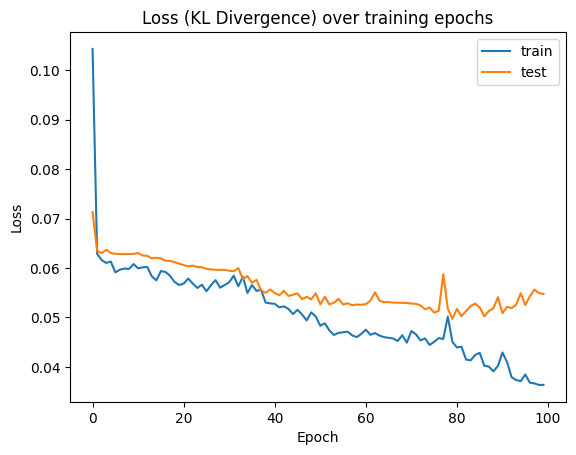

In [174]:
# --- Plot training history ---
plt.plot(model_loaded.history['train_loss'], label="train")
plt.plot(model_loaded.history['test_loss'], label="test")
plt.title("Loss (KL Divergence) over training epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Summarize model performance
With the model trained, we now evaluate its predictive accuracy on the held-out test set. To provide context for the SynergyGT model's performance, we compare it against two baseline models:
* **Mean Baseline:** A model that simply predicts the average distribution of interaction types found in the training data for every sample. The average distribution is approximately 24% antagonistic, 47% additive, and 29% synergistic ([0.24, 0.47. 0.29]).
* **Uninformative (Uniform) Baseline:** A "naive" model that assigns an equal probability (1/3) to all interaction types, representing a state of total uncertainty.

In [167]:
model_metrics = model_loaded.history['test_metrics'][0]
mean_baseline_metrics = naive_baseline(model, train_loader, test_loader, loss_fn, baseline_type='mean', smoothed_label=True, C=C)
uninformative_baseline_metrics = naive_baseline(model, train_loader, test_loader, loss_fn, baseline_type='uniform', smoothed_label=True, C=C)

Calculating average distribution on the training data for this fold...
Initializing the naive model with the calculated average...
Evaluating the model on the held-out data...


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]


Setting up the uniform distribution baseline...
Initializing the uniform baseline model...
Evaluating the model on the held-out data...


Eval:   0%|          | 0/6 [00:00<?, ?it/s]/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/eval.py:84: RuntimeWarning: Mean of empty slice
  return np.nanmean(tau_scores)
Eval: 100%|██████████| 6/6 [00:00<00:00, 28.18it/s]


Because the SynergyGT model outputs a probability distribution across three categories—Antagonistic, Additive, and Synergistic—we use metrics that measure both classification quality and distributional similarity:
* **Multiclass AUROC (Area Under the Receiver Operating Characteristic Curve):** Measures the model's ability to distinguish each effect type from the others. A higher score indicates better overall discrimination.
* **Multiclass AUPRC (Area Under the Precision-Recall Curve):** Evaluates the balance between precision and recall for each effect type.
* **KL Divergence (Kullback-Leibler Divergence):** Quantifies the difference between the model's predicted label distribution and the Bayesian-smoothed ground truth. Lower values indicate that the model's "beliefs" closely match the biological observations.

In [168]:
get_synergy_model_performance(model_metrics, uninformative_baseline_metrics, mean_baseline_metrics)


=== Test Set Model Performance ===

--- Overall Comparison---
                 Model  AUROC (macro)  AUPRC (macro)  Avg. KL Divergence
            Synergy GT           0.76           0.50                0.05
Uninformative Baseline           0.50           0.33                0.11
         Mean Baseline           0.50           0.33                0.06

--- Per-Class AUROC Comparison ---
                        Antagonistic  Neither  Synergistic
Synergy GT                      0.63     0.81         0.83
Uninformative Baseline          0.50     0.50         0.50
Mean Baseline                   0.50     0.50         0.50

--- Per-Class AUPRC Comparison ---
                        Antagonistic  Neither  Synergistic
Synergy GT                      0.06     0.91         0.51
Uninformative Baseline          0.04     0.78         0.18
Mean Baseline                   0.04     0.78         0.18


### Plot predicted synergy probabilities
Here we examine the model's behavior at the sample level. The code below focuses specifically on the Synergistic class since it is the primary interaction of interest.

We generate a scatter plot comparing the true synergy probabilities (derived from Bayesian-smoothed experimental data) against predicted synergy probabilities generated by the model's softmax output. A high positive Pearson's correlation between true and predicted values indicates the model is successfully ranking double mutants by their synergistic potential.

Eval: 100%|██████████| 6/6 [00:00<00:00, 17.16it/s]


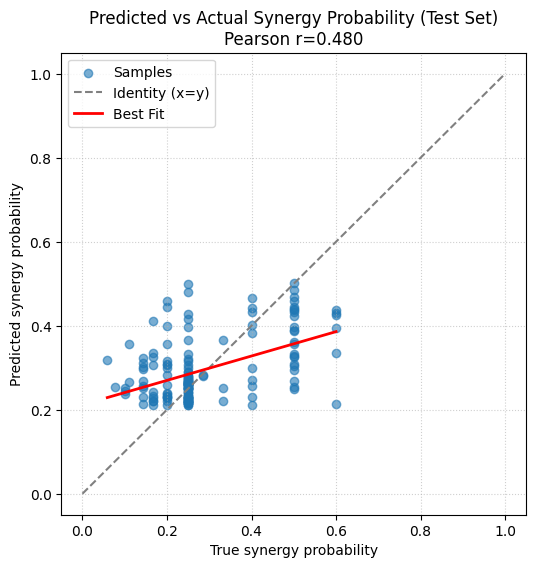

In [169]:
test_preds = get_predictions_synergy_model(model_loaded, test_loader, label_name='target_soft_smoothed', device=device)

preds = np.array(test_preds['preds'])
labels = np.array(test_preds['labels'])

pred_synergy = preds[:, 2]
label_synergy = labels[:, 2]

p_corr, _ = pearsonr(label_synergy, pred_synergy)

m, b = np.polyfit(label_synergy, pred_synergy, 1)
x_fit = np.linspace(label_synergy.min(), label_synergy.max(), 100)
y_fit = m * x_fit + b

plt.figure(figsize=(6, 6))
plt.scatter(label_synergy, pred_synergy, alpha=0.6, label='Samples')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Identity (x=y)")
plt.plot(x_fit, y_fit, color="red", linestyle="-", linewidth=2, label=f"Best Fit")
plt.xlabel("True synergy probability")
plt.ylabel("Predicted synergy probability")
plt.title(f"Predicted vs Actual Synergy Probability (Test Set)\nPearson r={p_corr:.3f}")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Inspecting the model

### Visualizing the [PAIR] token
Synergy GT relies on what's known as a summarization token to classify double mutants based on their joint subgraph. For every gene pair subgraph, a synthetic node called the [PAIR] token (commonly known as the [CLS] token in NLP, renamed here to suit the task), is added and given edges connecting it to all other nodes. In the model's attention mechanism, the [PAIR] token is made to attend to all other nodes, but no other nodes attend to it, so the representation it learns can be thought of as a summary of the subgraph. This representation is used to make the final prediction for a given double mutant; thus, the [PAIR] token learns how to best aggregate a subgraph's information such that it is useful for predicting the double mutant's effect type distribution.

To understand the model's ability to distinguish between double mutants that have "synergistic" as the maximum effect type in their effect type distribution from those that do not, visualize the [PAIR] token's representation for every sample in the training and testing data. If the model excels at this, we should see the [PAIR] representations of synergistic samples (double mutants that have "synergistic" as the maximum effect type in their effect type distribution) cluster together after dimensionality reduction, since the [PAIR] representations are what the model decodes to make decisions.

Extracting [PAIR] representations...
Running t-SNE on 802 total pairs... (641 train, 161 test)


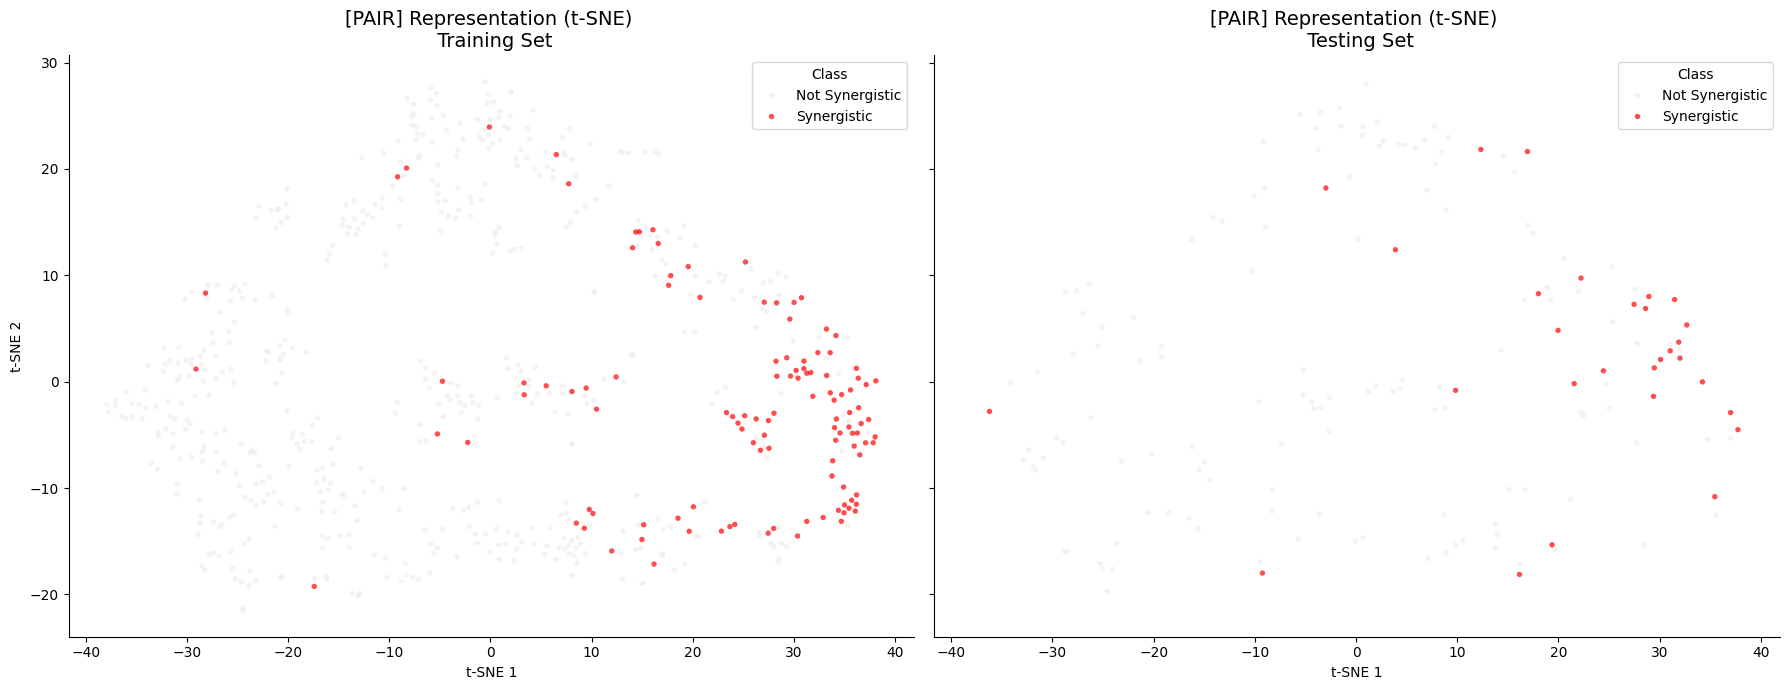

In [170]:
# --- Visualize the decision space ---
visualize_synergy_landscape(model_loaded, train_loader, test_loader, method='tsne', device='mps')

### Analyzing the most-attended genes
The model's attention mechanism can be used to identify the most attended genes across all subgraphs in the training data. This can be useful for understanding the model's ability to learn which non-focal genes are globally relevant to the prediction task. For example, the model may learn to give additional weight to hub genes that are known lifespan regulators, and thus may be able to predict synergy more accurately for pair subgraphs that contain those genes.

To better understand what genes are globally important to the model, identify genes with the highest average attention given to them by the [PAIR] token and all other tokens when they are NOT one of the two focal nodes (in the pair).

In [177]:
# --- Analyze top-10 nodes with at least 50 occurrences ---
analyze_top_attended_nodes(model_loaded, train_loader, id2node, device, top_k=10, min_occurrences=30)

--- Starting Top-10 Node Attention Analysis ---


Scanning Node Attention: 100%|██████████| 21/21 [00:01<00:00, 13.14it/s]


=== Highest Attention from [PAIR] Token (Top 10) ===
Rank  | Node Name/ID                   | Avg Attn     | Occur  | Aging  | In-Deg | Out-Deg
----------------------------------------------------------------------------------------------------
1     | ckr-2 (7433)                   | 0.115194     | 48     | YES    | 1      | 2     
2     | trx-1 (4278)                   | 0.070987     | 270    | YES    | 3      | 8     
3     | smo-1 (13)                     | 0.070565     | 52     | No     | 1737   | 202   
4     | sbds-1 (3229)                  | 0.064824     | 48     | No     | 1      | 2     
5     | let-7 (2375)                   | 0.060251     | 40     | No     | 127    | 188   
6     | tmed-10 (9503)                 | 0.054455     | 49     | No     | 0      | 7     
7     | R12E2.13 (8362)                | 0.053942     | 82     | No     | 0      | 8     
8     | arid-1 (1337)                  | 0.050214     | 121    | No     | 1      | 481   
9     | tbx-8 (54)                

**Observation:** Based on the prevalence of aging-associated genes in these lists and the fact that aging-associated genes make up only ~6% of all nodes seen by the model during training, the model seems to have learned to give importance to known aging-associated genes.